In [112]:
import setGPU

import tensorflow as tf

import csv, os, shutil
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import seaborn as sns
import pandas as pd
import bm3d, math

### Load the csv file, separate the data based on different classes and check the no.of samples in each class ###

In [55]:
csv_file_path = '../data/gicsd_labels.csv'
src_data_path = '../data/images'
classes_data_path = '../data/classes'
if not os.path.exists(classes_data_path):
    os.makedirs(classes_data_path)

In [3]:
data = pd.read_csv(csv_file_path, header=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   IMAGE_FILENAME  800 non-null    object
 1    LABEL          800 non-null    object
dtypes: object(2)
memory usage: 12.6+ KB


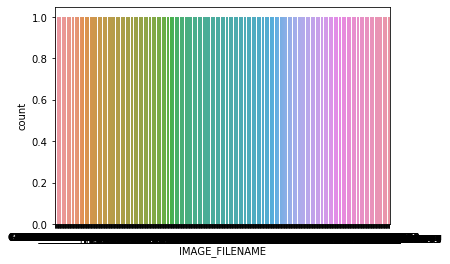

In [4]:
sns.countplot(x="IMAGE_FILENAME", data=data)

In [5]:
def read_csv_file():
    with open(csv_file_path) as file:
        reader = csv.reader(file)
        try:
            for row in reader:
                if row[0] == 'IMAGE_FILENAME' or row[1] == 'LABEL':
                    continue
                src_file_path = os.path.join(src_data_path, row[0])
                dst_path = os.path.join(classes_data_path, row[1].strip())
                if not os.path.exists(dst_path):
                    os.makedirs(dst_path)
                dst_file_path = os.path.join(dst_path, row[0])
                shutil.copy(src_file_path, dst_file_path)
                    
        except csv.Error as e:
            sys.exit('line {}, {}'.format(reader.line_num, e))

In [6]:
read_csv_file()

In [56]:
def display_samples_distribution(classes, each_class_samples):
    index = np.arange(len(classes))
    plt.bar(index, each_class_samples)
    plt.xlabel('Genre', fontsize=5)
    plt.ylabel('No of samples', fontsize=5)
    plt.xticks(index, classes, fontsize=5, rotation=30)
    plt.title('No of samples in each class')
    plt.show()

646 123 31


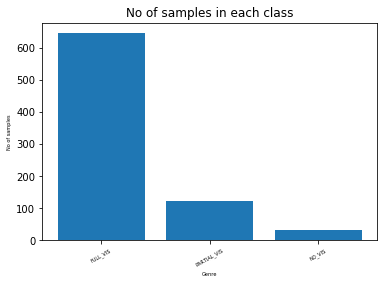

In [57]:
fv_path = '../data/classes/FULL_VISIBILITY'
pv_path = '../data/classes/PARTIAL_VISIBILITY'
nv_path = '../data/classes/NO_VISIBILITY'

images_fv = os.listdir(fv_path)
images_pv = os.listdir(pv_path)
images_nv = os.listdir(nv_path)
print(len(images_fv), len(images_pv), len(images_nv))

classes=['FULL_VIS', 'PARTIAL_VIS', 'NO_VIS']
each_class_samples = [len(images_fv), len(images_pv), len(images_nv)]

display_samples_distribution(classes, each_class_samples)

### Analyse a few samples in each category visually to check the noise level and plot distribution of each sample channels from each class 
### and find out PSNR value between noisy and non-noisy level

In [105]:
def display_images(images_fv, images_pv, images_nv, n):
    plt.figure(figsize=(24,4))
    for i in range(n):
        ax = plt.subplot(3, n, i+1)
        if i == 0:
            plt.title('fv_images', fontsize=12)
        plt.imshow(images_fv[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3, n, i+1+n)
        if i == 0:
            plt.title('pv_images', fontsize=12)
        plt.imshow(images_pv[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
        ax = plt.subplot(3, n, i+1+2*n)
        if i == 0:
            plt.title('nv_images', fontsize=12)
        plt.imshow(images_nv[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

646 123 31


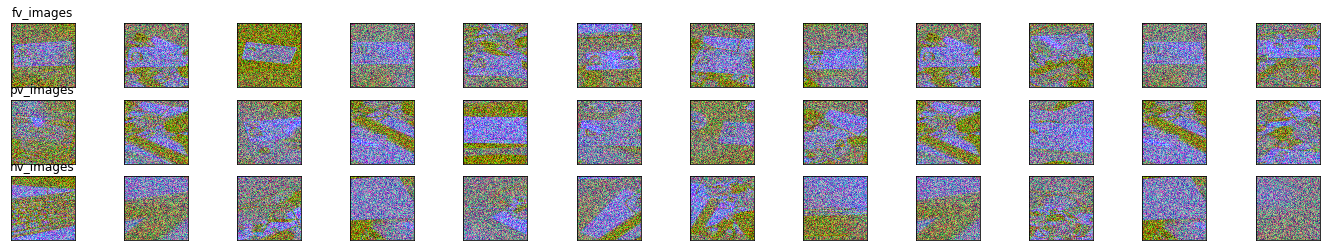

In [8]:
raw_images_fv = []
raw_images_pv = []
raw_images_nv = []
n = 12
for i in range(n):
    rInd = np.random.randint(0, len(images_nv)-1)
    raw_images_fv.append(cv.cvtColor(cv.imread(os.path.join(fv_path, images_fv[rInd])), cv.COLOR_BGR2RGB))
    raw_images_pv.append(cv.cvtColor(cv.imread(os.path.join(pv_path, images_pv[rInd])), cv.COLOR_BGR2RGB))
    raw_images_nv.append(cv.cvtColor(cv.imread(os.path.join(nv_path, images_nv[rInd])), cv.COLOR_BGR2RGB))
    
display_images(raw_images_fv, raw_images_pv, raw_images_nv, n)

In [83]:
def display_img_3channel_hist(img):
    plt.subplot(221), plt.imshow(img), plt.axis('off')
    color = ('b','g','r')
    plt.subplot(222)
    plt.axis('off')
    for i,col in enumerate(color):
        histr = cv.calcHist([img],[i],None,[256],[0,256])
        plt.plot(histr,color = col)
        plt.xlim([0,256])
    plt.show()

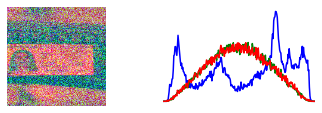

In [84]:
""" dispaly full visibility image and it's distribution """
img = cv.imread(os.path.join(fv_path, images_fv[0]))
display_img_3channel_hist(img)

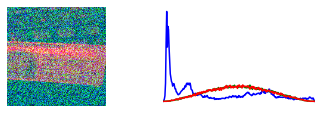

In [85]:
""" dispaly partial visibility image and it's distribution """
img = cv.imread(os.path.join(pv_path, images_pv[0]))
display_img_3channel_hist(img)

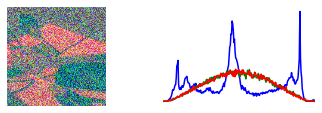

In [86]:
""" dispaly no visibility image and it's distribution """
img = cv.imread(os.path.join(nv_path, images_nv[0]))
display_img_3channel_hist(img)

### Anaylise single image to check the noise level apply noise reduction algorithm in case if that helps and analyse each channel ###

In [67]:
def display_single_image(img, title):
    plt.imshow(img)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

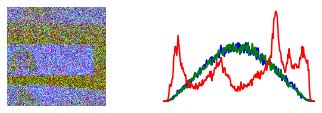

In [80]:
img = cv.cvtColor(cv.imread(os.path.join(fv_path, images_fv[0])), cv.COLOR_BGR2RGB)
display_img_hist(img)

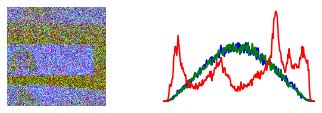

In [81]:
denoised_image = bm3d.bm3d(img + 0.5, sigma_psd=30/255, stage_arg=bm3d.BM3DStages.ALL_STAGES)#HARD_THRESHOLDING)
d_img = denoised_image.astype(np.uint8)

display_img_hist(d_img)

In [97]:
def display_img_1channel_hist(img):
    plt.subplot(221)
    plt.imshow(img)
    plt.axis('off')
    
    plt.subplot(222)
    plt.axis('off')
    histr = cv.calcHist([img], [0], None, [256], [0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
    plt.show()

original image shape:(192, 192, 3), single channel shape:(192, 192)


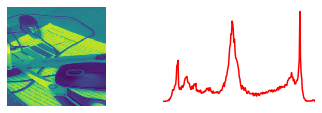

In [98]:
r, g, b = cv.split(img)
print("original image shape:{}, single channel shape:{}".format(img.shape, b.shape))
display_img_1channel_hist(r)

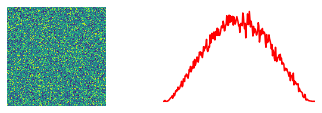

In [101]:
display_img_1channel_hist(g)

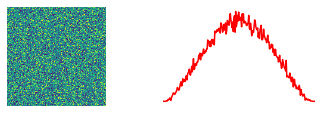

In [102]:
display_img_1channel_hist(b)

In [114]:
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * math.log10(max_pixel / math.sqrt(mse)) 
    return psnr 

In [115]:
"""
r - is noise-less channel image
b - noisy channel image
"""
value = PSNR(r, g) 
print(f"PSNR value is {value} dB")

PSNR value is 27.91425569476736 dB


In [103]:
def get_single_channel_image(file_path):
    img = cv.imread(file_path)
    b, g, r = cv.split(img)
    return b

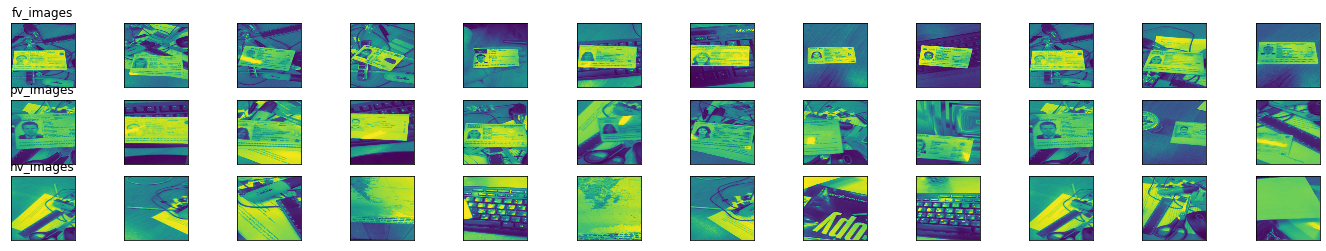

In [106]:
raw_images_fv = []
raw_images_pv = []
raw_images_nv = []
n = 12
for i in range(n):
    rInd = np.random.randint(0, len(images_nv)-1)
    raw_images_fv.append(get_single_channel_image(os.path.join(fv_path, images_fv[rInd])))
    raw_images_pv.append(get_single_channel_image(os.path.join(pv_path, images_pv[rInd])))
    raw_images_nv.append(get_single_channel_image(os.path.join(nv_path, images_nv[rInd])))
    
display_images(raw_images_fv, raw_images_pv, raw_images_nv, n)

### Single channels images - extract sharp data from noisy data and dump them as separate files ###

In [92]:
"""
Sepearte the single channle image form original noisy image and dumps in the given path
@aug_data_path: path where all the augmented or oringal images present
@single_channel_path: path where all single channel images will be stored
"""
def dump_single_channel_image(aug_data_path, single_channel_path):
    files = os.listdir(aug_data_path)
    for file in files:
        file_path = os.path.join(aug_data_path, file)

        img = get_single_channel_image(file_path)
        base, ext = file.split('.')
        file_name = base+'_SC'+'.'+ext
        sc_file_path = os.path.join(single_channel_path, file_name)
        cv.imwrite(sc_file_path, img)

In [93]:
"""Extract single channel images and store them in the created files"""

fv_single_channel_path = '../data/single_channel_images/FULL_VISIBILITY'
if not os.path.exists(fv_single_channel_path):
    os.makedirs(fv_single_channel_path)

pv_single_channel_path = '../data/single_channel_images/PARTIAL_VISIBILITY'
if not os.path.exists(pv_single_channel_path):
    os.makedirs(pv_single_channel_path)

nv_single_channel_path = '../data/single_channel_images/NO_VISIBILITY'
if not os.path.exists(nv_single_channel_path):
    os.makedirs(nv_single_channel_path)

""" full_visibility files path """
fv_aug_path = '../data/classes_aug/FULL_VISIBILITY'
dump_single_channel_image(fv_aug_path, fv_single_channel_path)
    
""" partial_visibility files path """
pv_aug_path = '../data/classes_aug/PARTIAL_VISIBILITY'
dump_single_channel_image(pv_aug_path, pv_single_channel_path)
    
""" no_visibility files path """
nv_aug_path = '../data/classes_aug/NO_VISIBILITY'
dump_single_channel_image(nv_aug_path, nv_single_channel_path)

In [ ]:
""" check the distribution of single channel images"""
classes=['FULL_VIS', 'PARTIAL_VIS', 'NO_VIS']
each_class_samples = [len(os.listdir(fv_single_channel_path)), len(os.listdir(pv_single_channel_path)), len(os.listdir(nv_single_channel_path))]
display_samples_distribution(classes, each_class_samples)

### Over-sampling by applying data augmentation ###

In [74]:
def generate_aug_file_names(filename, ind):
    head, tail = os.path.split(filename)
    base, ext = tail.split('.')
    nfilename = base+str(ind)+'.'+ext
    file_path = os.path.join(head, nfilename)
    return file_path

In [75]:
"""
@src_file_path: path fo the original image
@aug_file_path: path where the augmented file needs to be copied
@angle: roation angle
@operation: what operation should be applied to augment the data
"""
def augment_file(src_file_path, aug_file_path, angle, class_type, operation):
    img = cv.imread(src_file_path)
    b, g, r = cv.split(img)
    img_to_arr = tf.keras.preprocessing.image.img_to_array(img)
    sample = np.expand_dims(img_to_arr, 0)
    if operation == 'rotation':
        datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=angle)
    elif operation == 'brightness':
        datagen = tf.keras.preprocessing.image.ImageDataGenerator(brightness_range=[0.2,1.0])
    elif operation == 'zoom':
        datagen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=[0.5,1.0])
    
    no_of_samples_to_consider = 1
    if class_type == 'no_vis':
        no_of_samples_to_consider = 2
        
    it = datagen.flow(sample, batch_size = 1)
    for ind in range(no_of_samples_to_consider):
        batch_ = it.next()
        aug_file_path = generate_aug_file_names(aug_file_path, ind)
        cv.imwrite(aug_file_path, batch_[0].astype(np.uint8))
    
    #display_single_image(batch_[0].asytpe(np.uint8))

In [76]:
"""
@aug_data_path: where augmented data needs to be stored
@files_path: where all the original class data stored
@angles: list contains all the angles that we want to rotate an image
@operation: by default it is rotation
"""
def trigger_rotation_aug(aug_data_path, files_path, angles, class_type, operation='rotation'):
    """ Create a base path if does not exists already """
    if not os.path.exists(aug_data_path):
        os.makedirs(aug_data_path)
        
    """ Dump the images in particular operation for more clarity to visualize """
    aug_data_path = os.path.join(aug_data_path, operation) 
    if not os.path.exists(aug_data_path):
        os.makedirs(aug_data_path)

    files = os.listdir(files_path)
    def process_aug(operation, angle=0):
        for file in files:
            src_file_path = os.path.join(files_path, file)

            """ create augment file path where it is needs to be saved"""
            base, ext = file.split('.')
            if operation == 'rotation':
                aug_file_name = base+'_rot_'+str(angle)+'.'+ext
            else:
                aug_file_name = base+'_'+operation+'.'+ext
            aug_file_path = os.path.join(aug_data_path, aug_file_name)
            
            augment_file(src_file_path, aug_file_path, angle, class_type, operation)

    if operation == 'rotation':
        for angle in angles:
            process_aug(angle, operation)
    elif operation == 'zoom':
        process_aug(operation)
    elif operation == 'brightness':
        process_aug(operation)

In [78]:
""" Augment data with different roation analges"""
class_type = 'no_vis'
operation = 'zoom'
if class_type == 'no_vis':
    nv_angles = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170]
    nv_aug_data_path = '../data/aug_data/NO_VISIBILITY'
    trigger_rotation_aug(nv_aug_data_path, nv_path, nv_angles, class_type, operation)
elif class_type == 'partial_vis':
    pv_angles = [30, 60, 90, 120, 150]
    pv_aug_data_path = '../data/aug_data/PARTIAL_VISIBILITY'
    trigger_rotation_aug(pv_aug_data_path, pv_path, pv_angles, class_type, operation)
elif class_type == 'full_vis':
    fv_angle = [90]
    fv_aug_data_path = '../data/aug_data/FULL_VISIBILITY'
    trigger_rotation_aug(fv_aug_data_path, fv_path, fv_angle, class_type, operation)

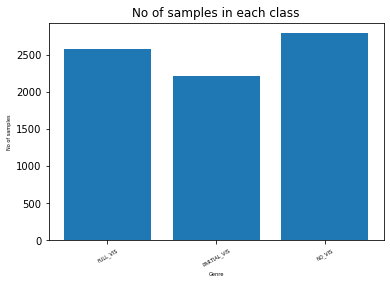

In [94]:
fv_class_aug_data_path = '../data/classes_aug/FULL_VISIBILITY'
pv_class_aug_data_path = '../data/classes_aug/PARTIAL_VISIBILITY'
nv_class_aug_data_path = '../data/classes_aug/NO_VISIBILITY'

classes=['FULL_VIS', 'PARTIAL_VIS', 'NO_VIS']
each_class_samples = [len(os.listdir(fv_class_aug_data_path)), len(os.listdir(pv_class_aug_data_path)), len(os.listdir(nv_class_aug_data_path))]
display_samples_distribution(classes, each_class_samples)

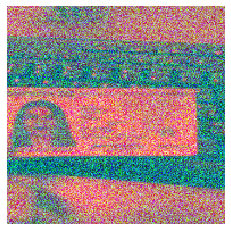

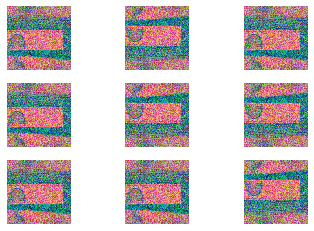

In [36]:
"""
check an operation and see how the range works
"""
data = cv.imread(os.path.join(fv_path, images_fv[0]))
plt.imshow(data)
plt.axis('off')
plt.show()
samples = np.expand_dims(data, 0)
datagen = tf.keras.preprocessing.image.ImageDataGenerator(vertical_flip=True)
it = datagen.flow(samples, batch_size=1)
for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image6 = batch[0].astype('uint8')
    plt.imshow(image6)
    plt.axis('off')

plt.show()

### Load augmented data, split as 60% train data, 20% validation data and 20% as testing data ###

In [50]:
class data_split(object):
    def __init__(self, orig_data_path):
        self.train_samples = 0
        self.valid_samples = 0
        self.test_samples = 0
        
        self.files = []
        self.src_data_path = orig_data_path
        self.class_src_data_path = ""

    """
    create the dest respective folders given high level path where classes path needs to be created
    @data_path: High level path where classes folders need to be created
    """
    def create_output_data_folders(self, data_path):
        if not os.path.exists(data_path):
            os.makedirs(data_path)
        
        fv_data_path = os.path.join(data_path, "FULL_VISIBILITY")
        if not os.path.exists(fv_data_path):
            os.makedirs(fv_data_path)

        pv_data_path = os.path.join(data_path, "PARTIAL_VISIBILITY")
        if not os.path.exists(pv_data_path):
            os.makedirs(pv_data_path)

        nv_data_path = os.path.join(data_path, "NO_VISIBILITY")
        if not os.path.exists(nv_data_path):
            os.makedirs(nv_data_path)
        
        return (fv_data_path, pv_data_path, nv_data_path)
    
    """
    copy the data in the given respective folders
    @test_samples: no of samples in test data folder
    @valid_samples: no of samples in validation data folder
    @train_samples: no of samples in training folder
    @files: total no of files in a class
    @test_data_path: path where test files needs to be copied
    @valid_data_path: path where validation files needs to be copied
    @train_data_path: path where training files needs to be copied
    """
    def copy_data_in_res_folders(self, test_data_path, valid_data_path, train_data_path):
        for _ in range(self.test_samples):
            rInd = np.random.randint(0, len(self.files)-1)
            src_file_name = self.files[rInd]
            src_file_path = os.path.join(self.class_src_data_path, src_file_name)

            head, tail = os.path.split(src_file_name)
            dst_file_name = os.path.join(test_data_path, tail)
            shutil.copy(src_file_path, dst_file_name)
            self.files.pop(rInd)

        for _ in range(self.valid_samples):
            rInd = np.random.randint(0, len(self.files)-1)
            src_file_name = self.files[rInd]
            src_file_path = os.path.join(self.class_src_data_path, src_file_name)

            head, tail = os.path.split(src_file_name)
            dst_file_name = os.path.join(valid_data_path, tail)
            shutil.copy(src_file_path, dst_file_name)
            self.files.pop(rInd)

        for ind in range(self.train_samples):
            src_file_name = self.files[ind]
            src_file_path = os.path.join(self.class_src_data_path, src_file_name)

            head, tail = os.path.split(src_file_name)
            dst_file_name = os.path.join(train_data_path, tail)
            shutil.copy(src_file_path, dst_file_name)
            
    """
    Given all the dataset, it create respectove class folder in training, validation, testing and copies files in respective folders
    @dst_path: high level path where folders and sub-folders needs to be created
    @class_type: specify class type to create folder associated to it
    """
    def split_util_func(self, dst_path, class_type):
        self.files = os.listdir(self.class_src_data_path)
        no_files = len(self.files)

        """ split data as 60%, 20% and 20%"""
        self.train_samples = int(no_files*0.6)
        self.valid_samples = int(no_files*0.2)
        self.test_samples = int(no_files*0.2)
        print(self.train_samples, self.valid_samples, self.test_samples, type(self.files))

        """ create destination sub folders"""
        """ train data path with diffferent classes"""
        train_data_path = os.path.join(dst_path, 'training')
        fv_train_data_path, pv_train_data_path, nv_train_data_path = create_output_data_folders(train_data_path)

        """ validation data path with diffferent classes"""
        validation_data_path = os.path.join(dst_path, 'validation')
        fv_valid_data_path, pv_valid_data_path, nv_valid_data_path = create_output_data_folders(validation_data_path)

        """ test data path with diffferent classes"""
        test_data_path = os.path.join(dst_path, 'test')
        fv_test_data_path, pv_test_data_path, nv_test_data_path = create_output_data_folders(test_data_path)

        if class_type == 'full_vis':
            self.copy_data_in_res_folders(fv_test_data_path, fv_valid_data_path, fv_train_data_path)
        elif class_type == 'partial_vis':
            self.copy_data_in_res_folders(pv_test_data_path, pv_valid_data_path, pv_train_data_path)
        elif class_type == 'no_vis':
            self.copy_data_in_res_folders(nv_test_data_path, nv_valid_data_path, nv_train_data_path)
            
    def split_data(self, sci_tvt_path):

        self.class_src_data_path = os.path.join(self.src_data_path, 'FULL_VISIBILITY')
        self.split_util_func(sci_tvt_path, 'full_vis')

        self.class_src_data_path = os.path.join(self.src_data_path, 'PARTIAL_VISIBILITY')
        self.split_util_func(sci_tvt_path, 'partial_vis')

        self.class_src_data_path = os.path.join(self.src_data_path, 'NO_VISIBILITY')
        self.split_util_func(sci_tvt_path, 'no_vis')

In [51]:
single_channel_data_path = '../data/single_channel_images'
sci_tvt_path = '../data/sci_tvt/'
ds_obj = data_split(single_channel_data_path)
ds_obj.split_data(sci_tvt_path)

1550 516 516 <class 'list'>
1328 442 442 <class 'list'>
1674 558 558 <class 'list'>


In [52]:
train_data_path = '../data/sci_tvt/training/FULL_VISIBILITY/GICSD_9_9_293_zoom_SC.png'
img = cv.imread(train_data_path)
print(img.shape)

(192, 192, 3)
